In [1]:
import cellpose
from cellpose import models, io
from slideutils.utils import utils
# import utils
import numpy as np
import os

In [2]:
# load all images from directory /mnt/deepstore/PRISM/data/cellpose_train_data/tile_mask_pairs and separate them into images and masks. Images have format of name.tif and masks have format of name_cp_masks.png
image_dir = '/mnt/deepstore/Final_DeepPhenotyping/figures/segmentation_test/cellpose_train_data/tile_mask_pairs'
images = []
gt_masks = []
for filename in os.listdir(image_dir):
	if filename.endswith('_cp_masks.png'):
		image_name = filename.replace('_cp_masks.png', '.tif')
		mask_name = filename
		image_path = os.path.join(image_dir, image_name)
		mask_path = os.path.join(image_dir, mask_name)
		if os.path.exists(mask_path):
			images.append(io.imread(image_path))
			gt_masks.append(io.imread(mask_path))

In [3]:
model = models.CellposeModel(gpu=True, pretrained_model='/mnt/deepstore/Final_DeepPhenotyping/pipeline/model_weights/cellpose_model')
predicted_masks = []
for i in range(len(images)):
	# run the model on the image
	rgb = utils.channels_to_bgr(images[i], [0, 3], [2, 3], [1, 3])
	mask, _, _ = model.eval(
		rgb, diameter=15, channels=[0, 0], batch_size=8
	)
	predicted_masks.append(mask)

In [4]:
model = models.Cellpose(gpu=True,model_type='cyto3')
predicted_masks_cyto3 = []
for i in range(len(images)):
	# run the model on the image
	rgb = utils.channels_to_bgr(images[i], [0, 3], [2, 3], [1, 3])
	stuff = model.eval(
		rgb, diameter=15, channels=[0, 0], batch_size=8
	)
	predicted_masks_cyto3.append(stuff[0])


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# ----------------------------------------------------------------------
# 1.  Pixel‑level metrics
# ----------------------------------------------------------------------
def pixel_metrics(gt_mask: np.ndarray, pred_mask: np.ndarray) -> dict:
    gt_bin, pred_bin = gt_mask > 0, pred_mask > 0
    tn, fp, fn, tp = confusion_matrix(gt_bin.ravel(),
                                      pred_bin.ravel(),
                                      labels=[0, 1]).ravel()
    acc  = (tp + tn) / (tp + fp + fn + tn)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    dice = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) else 0.0
    iou  = tp / (tp + fp + fn) if (tp + fp + fn) else 0.0
    return dict(accuracy=acc, precision=prec, recall=rec, dice=dice, iou=iou)

# ----------------------------------------------------------------------
# 2.  Instance‑level helpers
# ----------------------------------------------------------------------
def _iou_matrix(gt_lbl, pred_lbl):
    g_ids = np.unique(gt_lbl)[1:]      # skip background 0
    p_ids = np.unique(pred_lbl)[1:]
    iou   = np.zeros((len(g_ids), len(p_ids)), float)

    for i, g in enumerate(g_ids):
        g_mask = gt_lbl == g
        for j, p in enumerate(p_ids):
            p_mask = pred_lbl == p
            inter = np.logical_and(g_mask, p_mask).sum()
            union = np.logical_or(g_mask,  p_mask).sum()
            iou[i, j] = inter / union if union else 0.0
    return iou, g_ids, p_ids

def instance_stats(gt_lbl, pred_lbl, thr=0.50):
    iou, _, _ = _iou_matrix(gt_lbl, pred_lbl)
    if iou.size == 0:                       # one of the images has no objects
        tp = 0
        fp = (pred_lbl > 0).astype(int).max()   # 0 or 1
        fn = (gt_lbl  > 0).astype(int).max()
        return dict(inst_tp=tp, inst_fp=fp, inst_fn=fn,
                    inst_precision=0.0, inst_recall=0.0,
                    inst_F1=0.0, inst_mean_iou=0.0, inst_mean_dice=0.0)

    row_ind, col_ind = linear_sum_assignment(1 - iou)
    matches = [(r, c) for r, c in zip(row_ind, col_ind) if iou[r, c] >= thr]

    tp = len(matches)
    fp = (np.unique(pred_lbl)[1:].size) - tp
    fn = (np.unique(gt_lbl )[1:].size) - tp

    mean_iou  = np.mean([iou[r, c] for r, c in matches]) if matches else 0.0
    mean_dice = np.mean([2*i/(1+i)     for r, c in matches
                         if (i := iou[r, c]) > 0])       if matches else 0.0

    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    F1   = 2*prec*rec / (prec + rec) if (prec + rec) else 0.0

    return dict(inst_tp=tp, inst_fp=fp, inst_fn=fn,
                inst_precision=prec, inst_recall=rec, inst_F1=F1,
                inst_mean_iou=mean_iou, inst_mean_dice=mean_dice)


In [11]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [20]:
# ----------------------------------------------------------------------
# 3.  Evaluate two model lists
# ----------------------------------------------------------------------
def evaluate_models(gt, predA, predB):
    if not (len(gt) == len(predA) == len(predB)):
        raise ValueError("Lists must be the same length and aligned image‑by‑image.")

    records = []
    for idx, (g, pA, pB) in enumerate(zip(gt, predA, predB)):
        # ----- Model A -----
        recA          = pixel_metrics(g, pA)
        recA.update(instance_stats(g, pA))
        recA.update(model='A', img_idx=idx)
        records.append(recA)

        # ----- Model B -----
        recB          = pixel_metrics(g, pB)
        recB.update(instance_stats(g, pB))
        recB.update(model='B', img_idx=idx)
        records.append(recB)

    df = pd.DataFrame.from_records(records)

    # mean ± SD for *continuous* metrics
    cont_cols = ['accuracy', 'precision', 'recall', 'dice', 'iou',
                 'inst_precision', 'inst_recall', 'inst_F1',
                 'inst_mean_iou', 'inst_mean_dice']
    summary = df.groupby('model')[cont_cols].agg(['mean', 'std']).round(4)

    return df, summary

In [21]:
df_per_image, df_summary = evaluate_models(gt_masks, predicted_masks, predicted_masks_cyto3)

In [22]:
print(df_summary)

      accuracy         precision          recall            dice          \
          mean     std      mean     std    mean     std    mean     std   
model                                                                      
A       0.9831  0.0096    0.9623  0.0389  0.9392  0.0535  0.9489  0.0277   
B       0.9505  0.0210    0.9903  0.0158  0.7241  0.0884  0.8334  0.0591   

          iou         inst_precision         inst_recall         inst_F1  \
         mean     std           mean     std        mean     std    mean   
model                                                                      
A      0.9041  0.0478         0.9884  0.0196      0.9893  0.0158  0.9887   
B      0.7188  0.0877         0.9585  0.0693      0.9730  0.0634  0.9655   

              inst_mean_iou         inst_mean_dice          
          std          mean     std           mean     std  
model                                                       
A      0.0142        0.9060  0.0416         0.9492  0.0

In [23]:
from scipy.stats import wilcoxon
for metric in ['dice', 'iou']:
    a = df_per_image.query("model=='A'")[metric]
    b = df_per_image.query("model=='B'")[metric]
    stat, p = wilcoxon(a, b)
    print(f"{metric}: p = {p:.4e}")


dice: p = 3.4969e-103
iou: p = 3.8583e-103


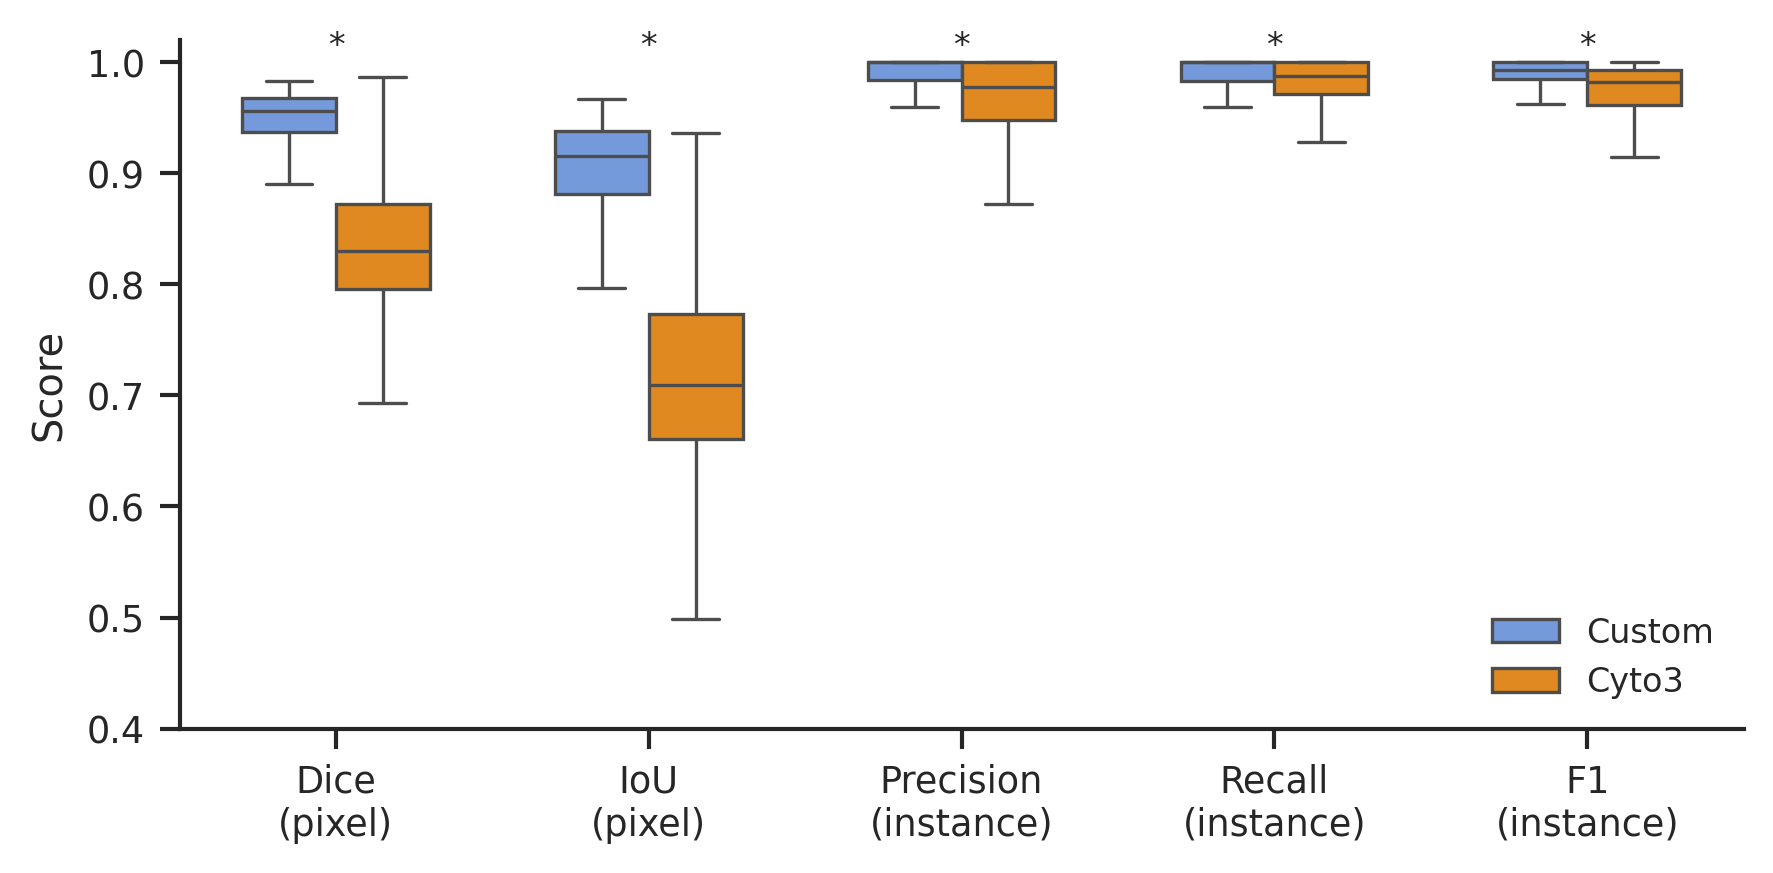

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# ── parameters ────────────────────────────────────────────────────────
metrics = ["dice", "iou", "inst_precision", "inst_recall", "inst_F1"]
pretty  = ["Dice\n(pixel)", "IoU\n(pixel)",
           "Precision\n(instance)", "Recall\n(instance)", "F1\n(instance)"]
metric_map = dict(zip(metrics, pretty))
alpha_fdr  = 0.01            # FDR level for significance star

# ── rename model labels in case the DataFrame still has 'A'/'B' ───────
df_per_image["model"] = (
    df_per_image["model"]
    .replace({"A": "Custom", "B": "Cyto3"})
)

# long‑form for seaborn
df_long = (df_per_image
           .melt(id_vars=["img_idx", "model"],
                 value_vars=metrics,
                 var_name="metric",
                 value_name="score"))
df_long["metric"] = df_long["metric"].map(metric_map)

# ── paired Wilcoxon & BH‑FDR (manual) ─────────────────────────────────
pvals = []
for m in metrics:
    x = df_per_image.query("model=='Custom'")[m].values
    y = df_per_image.query("model=='Cyto3'")[m].values
    pvals.append(wilcoxon(x, y, zero_method="wilcox").pvalue)

pvals = np.asarray(pvals)
m = len(pvals)
order = np.argsort(pvals)
qvals_sorted = pvals[order] * m / (np.arange(1, m + 1))
qvals_sorted = np.minimum.accumulate(qvals_sorted[::-1])[::-1]
qvals = np.empty_like(qvals_sorted)
qvals[order] = qvals_sorted
signif = qvals < alpha_fdr
q_lookup = dict(zip(pretty, zip(qvals, signif)))

# ── plot ──────────────────────────────────────────────────────────────
sns.set_theme(context="paper", style="ticks")
palette = {"Custom": "cornflowerblue", "Cyto3": "darkorange"}

fig, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(data=df_long, x="metric", y="score", hue="model",
            palette=palette, width=0.6, fliersize=0, linewidth=0.8, ax=ax)

# legend cleanup
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], frameon=False, fontsize=8,
          loc="lower right")

ax.set_ylim(0.4, 1.02)
ax.set_ylabel("Score")
ax.set_xlabel("")

# annotate stars where q < 0.05
for k, label in enumerate(pretty):
    q, sig = q_lookup[label]
    if sig:
        y_max = df_long.loc[df_long["metric"] == label, "score"].max()
        ax.text(k, 1.0, "*", ha="center", va="bottom", fontsize=8)

sns.despine(ax=ax)
fig.tight_layout()
fig.savefig("cellpose_comparison.pdf", dpi=600, bbox_inches="tight")
plt.show()


In [34]:
# Remove edge events from the predicted_masks and ground truth masks
# Removing edge events
for i, mask in enumerate(predicted_masks):
	labels = np.unique(np.concatenate([mask[0,:], mask[-1,:], mask[:,0], mask[:,-1]]))
	for label in labels:
		predicted_masks[i][mask == label] = 0

for i, mask in enumerate(predicted_masks_cyto3):
	labels = np.unique(np.concatenate([mask[0,:], mask[-1,:], mask[:,0], mask[:,-1]]))
	for label in labels:
		predicted_masks_cyto3[i][mask == label] = 0

for i, mask in enumerate(gt_masks):
	labels = np.unique(np.concatenate([mask[0,:], mask[-1,:], mask[:,0], mask[:,-1]]))
	for label in labels:
		gt_masks[i][mask == label] = 0

In [35]:
threshs = np.linspace(0.5, 1, 50)
ap_finetuned = cellpose.metrics.average_precision(predicted_masks, gt_masks, threshold=threshs)
ap_cyto3 = cellpose.metrics.average_precision(predicted_masks_cyto3, gt_masks, threshold=threshs)

/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/cellpose/metrics.py:196: RuntimeWarning: invalid value encountered in true_divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


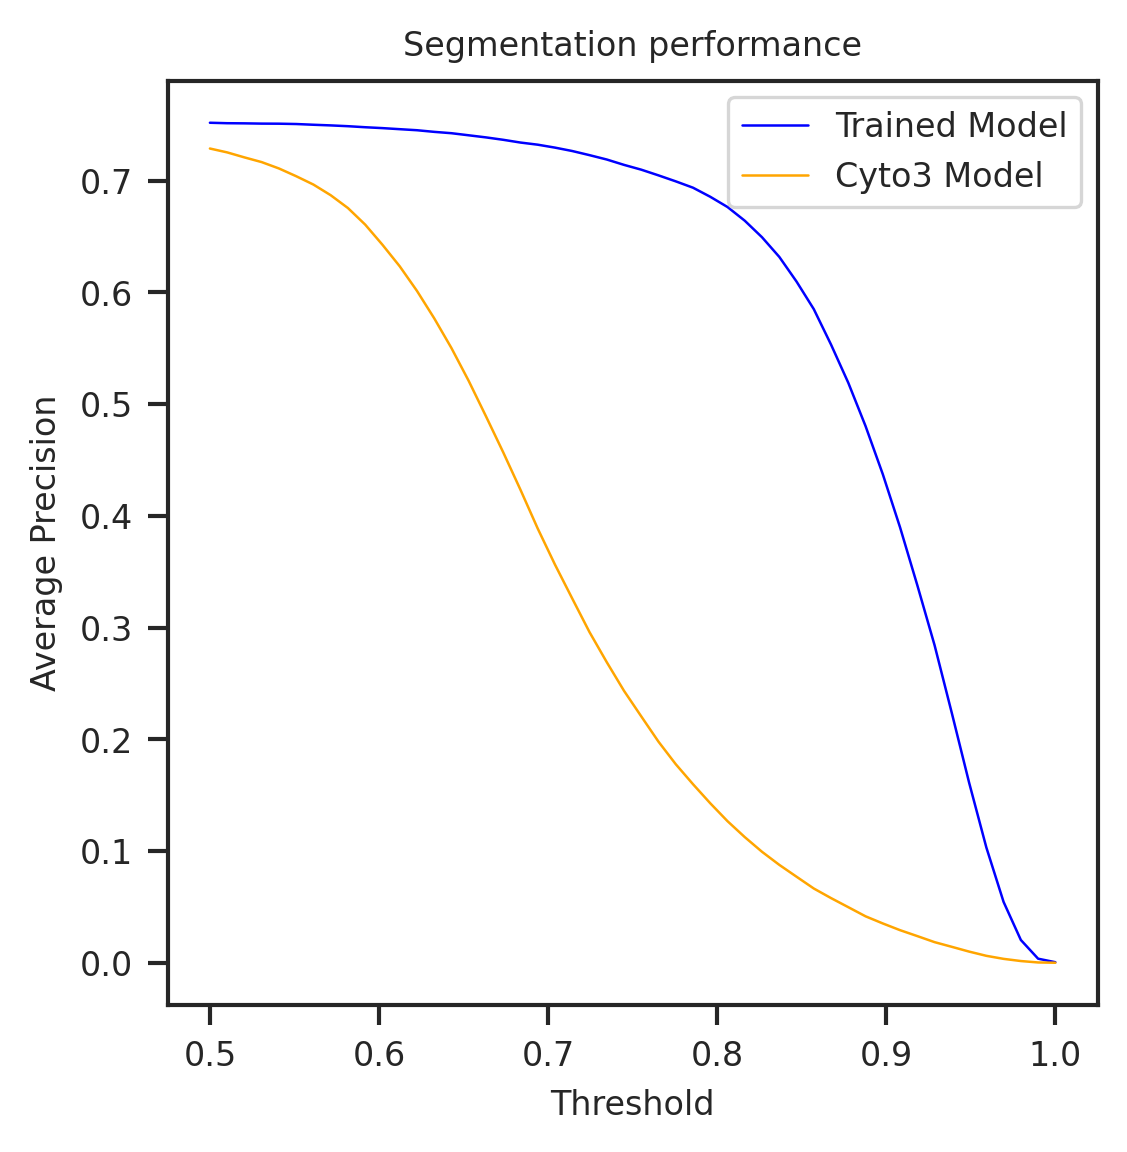

In [36]:
# plot both ap curves against threshs in one figure with legend
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl


# ---------- Matplotlib style (same as first script) ----------
plt.rcParams.update(
{
    "font.family": "Arial",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 0.6,
    "figure.dpi": 300,
    }
)

plt.figure(figsize=(4, 4))
plt.plot(threshs, ap_finetuned[0].mean(axis=0), label='Trained Model', color='blue')
plt.plot(threshs, ap_cyto3[0].mean(axis=0), label='Cyto3 Model', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Average Precision')
plt.title('Segmentation performance')
plt.legend()
# plt.grid()
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/segmentation_test/ap_curves.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
cellpose.metrics.